# DecGene analysis for 2022 paper, k=11
Latest update: Oct 3, 2022
Authors: Rob Cahill, Reza Abbasi (Abbasi Lab, UCSF)
Contact: robert.cahill@ucsf.edu


**Matching notebook to figures in paper:**
* Figure 1: TBD
* Figure 2: TBD
* Figure 3: TBD
* Figure 4: TBD
* Figure 5: TBD
* Figure S1: TBD
* Figure S2: TBD
* Figure S3: TBD

**Dependencies needed to run:**
* staNMF file
* PCA file
* file structure?

In [1]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import os
import pandas as pd
from pca_with_missing_values import pca_with_missing_values
import pickle
# from scipy import ndimage
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.optimize import nnls
import sklearn.preprocessing
from morans_index import runManyMoranI
from staNMF_ import staNMF
from staNMF.nmf_models import sklearn_nmf

In [2]:
import spams

In [3]:
font = {'family' : 'normal',
'weight' : 'regular',
'size'   : 18}
plt.rc('font', **font)

In [4]:
#load_data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

In [5]:
#load reference atlas
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

In [6]:
# preprocess compute the support
support = np.sum(areas_atlas, 0) > 0

Text(1, 3, 'support')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


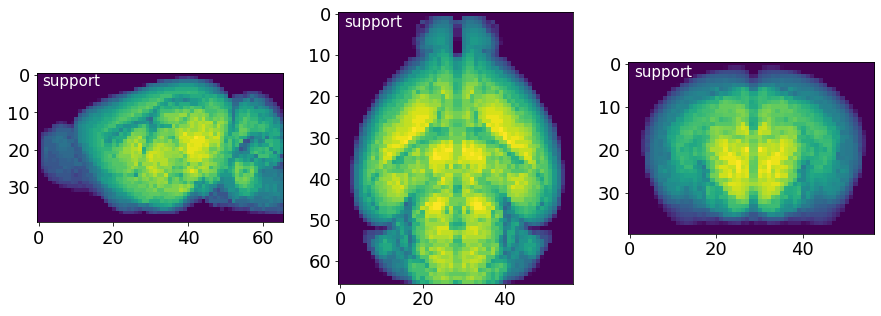

In [7]:
#visualize the support
_, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
a.imshow(np.mean(support[:, :, :], 2).T)
b.imshow(np.mean(support[:, :, :], 1))
c.imshow(np.mean(support[:, :, :], 0))
a.text(1, 3, 'support', color='w', fontsize=15)
b.text(1, 3, 'support', color='w', fontsize=15)
c.text(1, 3, 'support', color='w', fontsize=15)

In [8]:
# preprocess : get the data within the reference atlas
filtered_data = data[:,:-1,:-1,:-1][:, support]
filtered_data.shape

(4345, 55954)

In [9]:
###################################
# Create model with 11 PPs, coeffs
###################################

from sklearn_nmf import sklearn_nmf

nmf = sklearn_nmf(n_components=11, l1_ratio=1, alpha = 0, random_state=1)
nmf.fit(np.maximum(filtered_data,0)) # fit model

# Create PPs and coeffs
PPs = nmf.components_
coeffs = nmf.transform(np.maximum(filtered_data,0))
print(PPs.shape, coeffs.shape)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


(11, 55954) (4345, 11)


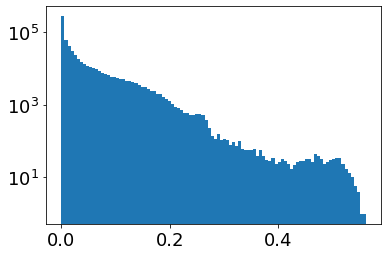

In [10]:
plt.hist(PPs.flatten(), bins=100)
plt.yscale('log')
plt.show()

In [11]:
# preprocess unmask
PPs_3d = np.zeros((len(PPs), 66, 40, 57))
PPs_3d[:,support] = PPs * (PPs > 0.05)
PPs_3d.shape

(11, 66, 40, 57)

In [12]:
# # Save model
# np.savez('staNMF_final_11_PPs',
#          PPs_3d=PPs_3d,
#          PPs=PPs,
#          coeffs=coeffs)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


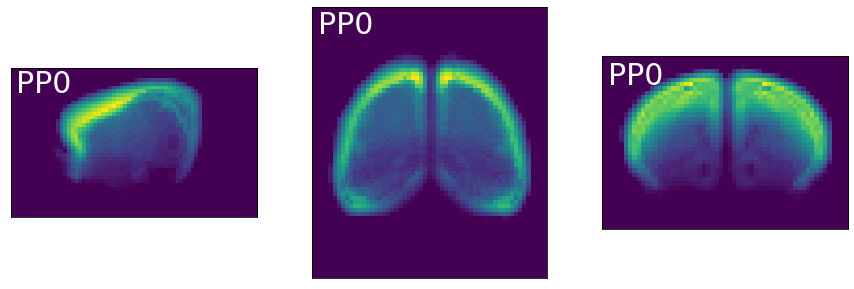

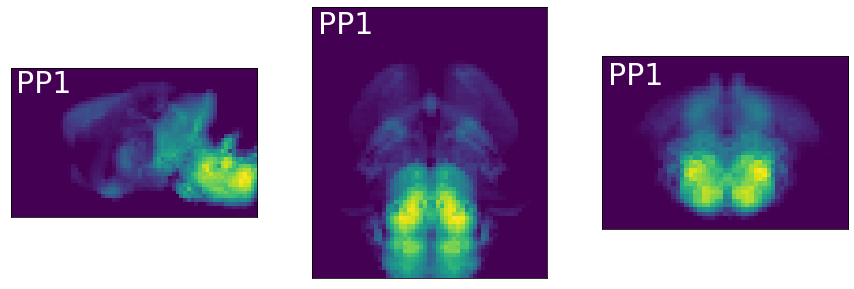

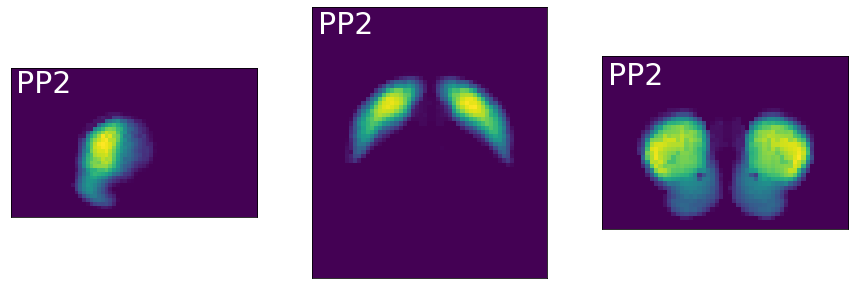

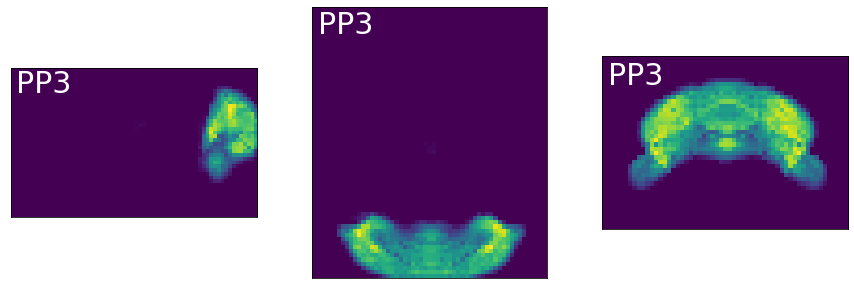

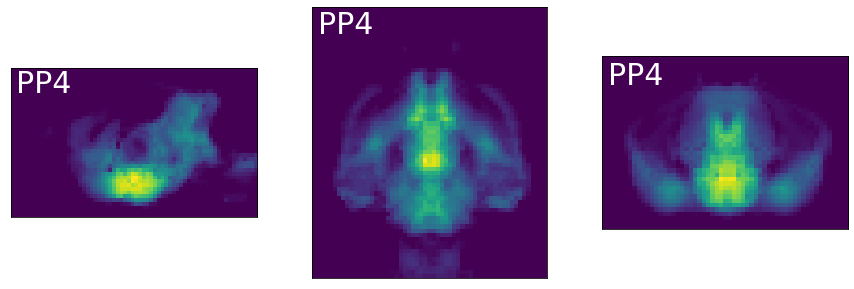

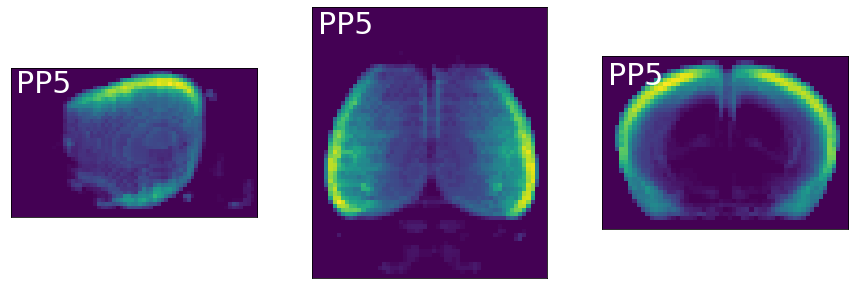

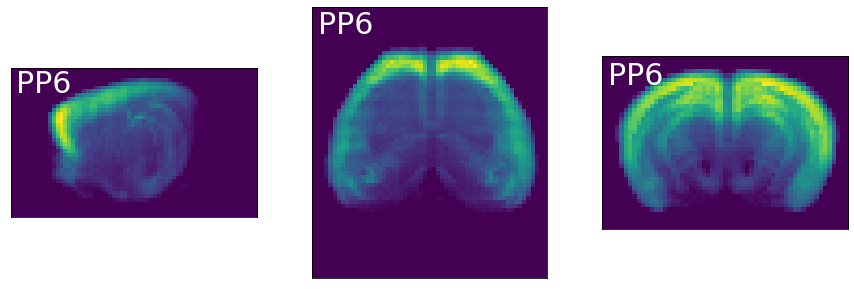

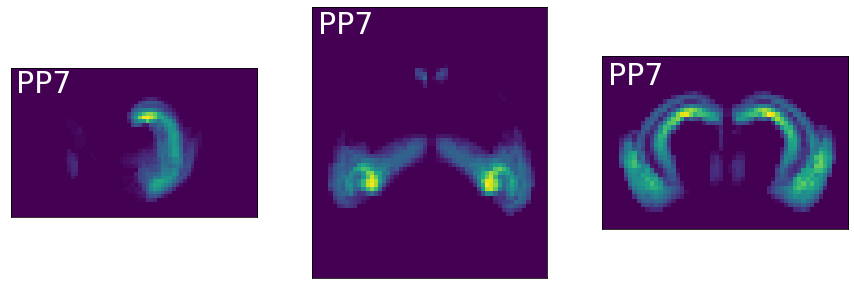

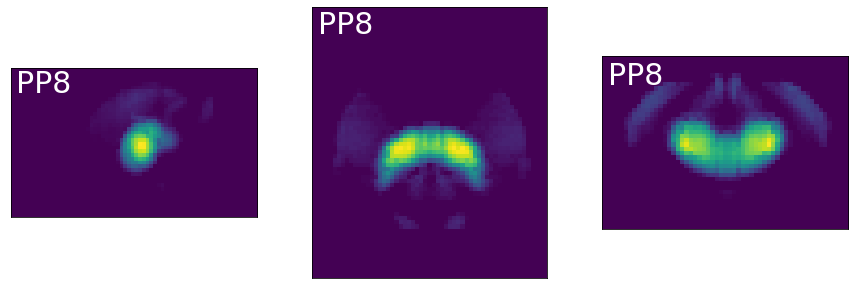

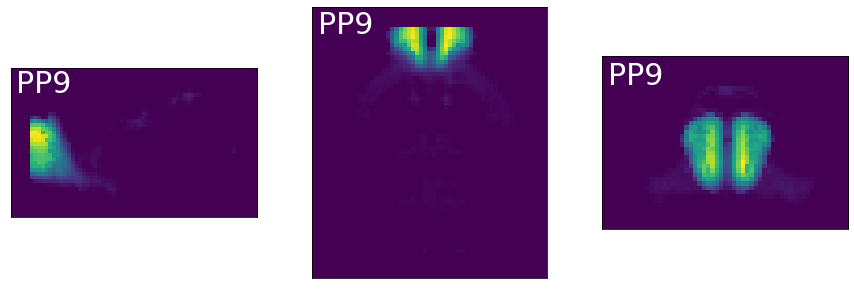

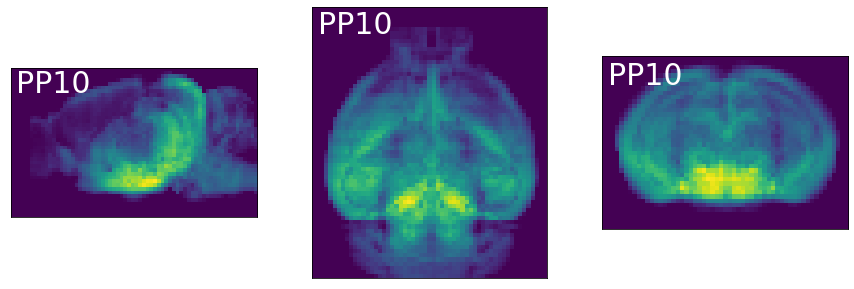

In [13]:
# visualize the PPs
for i in range(11):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(PPs_3d[i, :, :, :], 2).T)
    b.imshow(np.mean(PPs_3d[i, :, :, :], 1))
    c.imshow(np.mean(PPs_3d[i, :, :, :], 0))
    a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)

## Correlation map vs. CCF

In [14]:
### PUT IN correlations_to_CCF file

def correlation_map_with_CCF(PPs, original_shape, plot=True,
                             order_type = 1, area_order=None,
                             put_last_k = 0, save_fig = False, save_index = None):
    ''' Compare PPs with the standard ABA CCF.
    '''
    # transform PPs to 4d tensor
    PPs_3d = np.zeros([PPs.shape[0]] + original_shape[1:].tolist())
    num_pps = PPs.shape[0]
    for i in range(PPs.shape[0]):
        p2 = np.reshape(PPs[i,:], original_shape[1:])
        PPs_3d[i,:,:,:] = p2
    # load ABA CCF coarse
    areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
    mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')
    if area_order != None:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1)[np.array(area_order)], PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    else:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1), PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    
    if order_type == 1:
        rows, cols = linear_sum_assignment(-np.abs(cor_mat))
        factor_order = list(cols) + [x for x in range(num_pps) if x not in cols]
    elif order_type == 2:
        cols = np.argmax(np.abs(cor_mat), 0)
        if put_last_k > 0:
            # put the poorly fitted patterns at the last.
            best_fits = [abs(cor_mat[y, x]) for x, y in enumerate(cols)]
            orders = np.argsort(best_fits)
            for i in range(put_last_k):
                cols[orders[i]] = max(cols) 
        factor_order = np.argsort([ 10 * x - abs(cor_mat[x, i]) for i, x in enumerate(cols.tolist())]) # first sort by x, then sort by the value
                
            
    if plot:
        fig = plt.gcf()
        plt.figure(figsize=(10,9))
        plt.imshow(np.abs(cor_mat[:,factor_order]).tolist(), cmap='YlOrRd')
        if area_order is None:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[:]['name'].tolist()))
        else:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[area_order]['name'].tolist()))
        plt.ylim([-0.5, 11.5])
        plt.gca().invert_yaxis()
        plt.xticks(range(num_pps), factor_order)
        plt.title('Correlation Coefficient')
        plt.xlabel('Principle Patterns')
        plt.colorbar(shrink=.6)
        plt.savefig('../figures/corr_coeff.png')
        plotname = "corr_map.png"
        plt.savefig(plotname, dpi=300)
        plt.show()
    return np.abs(cor_mat[:,factor_order])

# linear prediction of the reference maps from PPs
**Fig. 4C** in manuscript

In [15]:
from scipy.optimize import nnls
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')
print(mouse_coarse_df.name)

0                  Midbrain
1                 Isocortex
2                   Medulla
3                Cerebellum
4           Olfactory areas
5         Cortical subplate
6                      Pons
7                  Pallidum
8     Hippocampal formation
9              Hypothalamus
10                 Thalamus
11                 Striatum
Name: name, dtype: object


In [16]:
# isocortex
ccf_ind = 1
nnls_predictor = np.array([PPs_3d[0, :, :, :].reshape(-1), PPs_3d[6, :, :, :].reshape(-1),PPs_3d[5, :, :, :].reshape(-1)]).T
nnls_coeffs = nnls(nnls_predictor, areas_atlas[ccf_ind,:].reshape(-1))
nnls_recon = np.matmul(nnls_coeffs[0], nnls_predictor.T)
print("corr coeff: ", np.corrcoef(nnls_recon, areas_atlas[ccf_ind,:].reshape(-1))[0,1])

corr_vals = []
for pp_ind in [0,6,5]:
    corr_vals.append(np.corrcoef(PPs_3d[pp_ind, :, :, :].reshape(-1), areas_atlas[ccf_ind,:].reshape(-1))[0,1])
    print("corr coeff: ", np.corrcoef(PPs_3d[pp_ind, :, :, :].reshape(-1), areas_atlas[ccf_ind,:].reshape(-1))[0,1])
    
print("corr coeff improve: ", -np.mean(corr_vals-np.corrcoef(nnls_recon, areas_atlas[ccf_ind,:].reshape(-1))[0,1]))

corr coeff:  0.8898975158877116
corr coeff:  0.7432757705978564
corr coeff:  0.7396940130353461
corr coeff:  0.6032425964932218
corr coeff improve:  0.1944933891789035


In [17]:
# isocortex - logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

ccf_ind = 1
lr = LogisticRegression()
aucs = []
np.random.seed(1)
n_sub_regions = 3
for iter_ind in range(1000):
    inds_lp = np.random.choice(11,n_sub_regions, replace=False)
    predictor_mat = np.zeros(PPs_3d[0, :, :, :].reshape(-1).shape)
    for ind_lp in inds_lp:
        predictor_mat = predictor_mat + PPs_3d[ind_lp, :, :, :].reshape(-1)
    lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
    aucs.append(roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), predictor_mat.reshape(-1,1)))
#     print(iter_ind, inds_lp, aucs[iter_ind])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


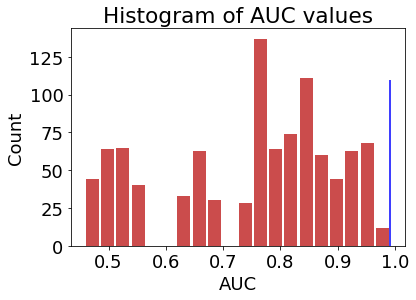

In [18]:
# isocortex - logistic regression

ccf_ind = 1
lr = LogisticRegression()
predictor_mat = np.sum([PPs_3d[0, :, :, :].reshape(-1), PPs_3d[6, :, :, :].reshape(-1),PPs_3d[5, :, :, :].reshape(-1)],axis=0)

lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
subregoion_auc = (roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), predictor_mat.reshape(-1,1)))

# for pp_ind in [0,6,5]:
#     lr.fit(PPs_3d[[pp_ind], :, :, :].reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
#     print(roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), PPs_3d[[pp_ind], :, :, :].reshape(-1,1)))

n, bins, patches = plt.hist(aucs, bins=20, color='#B50000',
                            alpha=0.7, rwidth=0.85)
#plt.grid(axis='y', alpha=0.75)
plt.vlines(subregoion_auc,0,110, colors='b')
plt.xlabel('AUC')
plt.ylabel('Count')
plt.title('Histogram of AUC values')
plt.savefig("../figures/AUC_isocortex", dpi=300)
plt.show()

In [19]:
# median values for isocortex simulations vs. highest value
np.median(aucs), subregoion_auc

(0.7777101646037853, 0.9916216678104839)

In [20]:
# isocortex – z-score calculation
from scipy import stats
zscore_data = aucs.copy()
zscore_data.append(subregoion_auc)
zscore_iso = stats.zscore(zscore_data)[-1]
zscore_iso, len(aucs)

(1.6345724638155243, 1000)

# number of PPs where coeffs have non-zero values
This looks at the 4,345 coeffs created by staNMF representing each gene. We want to understand how many PPs (from 0 to 11) each gene coefficient is represented in.

**Fig. 1E** in manuscript.

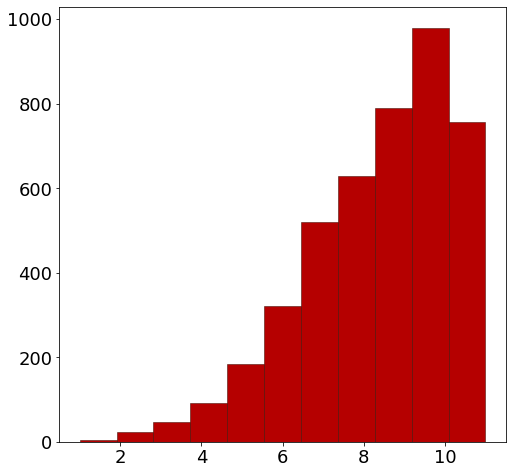

In [21]:
plt.figure(figsize=(8,8))
plt.hist(np.sum(coeffs!=0, axis=1), bins=11,  color='#B50000',edgecolor='#3C0B00', linewidth=0.5) #/ (coeffs.shape[0]*coeffs.shape[1])
plt.savefig("../figures/hist_num_PPs_non_zero_coeffs.png", dpi=300, transparent=True)

# histogram of gene reconstruction accuracy for staNMF vs. PCA

Calculation:
1. For each staNMF and PCA,
2. For each of the ~4350 genes,
3. Multiply the coeff for that gene x PP dictionary (the reconstructed gene),
4. Calculate Pearson correlation coeff of that reconstructed gene vs. the actual gene data. (reconstruction accuracy by gene)
5. Store each Pearson correlation coeff in a list.

Output: Two lists of ~4,350 correlation coeffs (gene reconstruction accuracy), one for staNMF, one for PCA

**Fig. 1F** in manuscript

In [22]:
def geneReconstructionAcccuracy(_PPs, _coeffs):
    """ function create gene-by-gene reconstruction accuracy """

    gene_rec_accuracy_lst = []

    # loop through each gene
    for i in range(len(_coeffs)):

        # reconstruct gene
        gene_rec = np.matmul(_coeffs[i], _PPs)

        # get actual gene value from ABA data
        gene_actual = np.maximum(filtered_data[i],0)

        # estimate Pearson corr coeff between gene reconstruction and original data
        corr = np.corrcoef(gene_rec,gene_actual)[0][1]

        # set to 0 if NaN
        if np.isnan(corr):
            corr = 0
        
        # add calculated correlation to list
        gene_rec_accuracy_lst.append(corr)        
    
    return gene_rec_accuracy_lst

In [23]:
# Run reconstruction function for for stanNMF / DecGene
gene_rec_accuracy_staNMF = geneReconstructionAcccuracy(_PPs=PPs, _coeffs=coeffs)

In [24]:
# Run reconstruction function for PCA

# load PCA model
tmp = np.load('../output/PCA_final_11_PPs.npz')
PPs_PCA = tmp['PPs']
coeffs_PCA = tmp['coeffs']

# run function
gene_rec_accuracy_PCA = geneReconstructionAcccuracy(_PPs=PPs_PCA, _coeffs=coeffs_PCA)

In [25]:
# Comparing mean accuracy and standard deviation
print("DecGene accuracy & std:",
      round(np.mean(gene_rec_accuracy_staNMF),3),
      ", std:",
      round(np.std(gene_rec_accuracy_staNMF),3))
print("PCA accuracy & std:",
      round(np.mean(gene_rec_accuracy_PCA),3),
      ", std:",
      round(np.std(gene_rec_accuracy_PCA),3))

DecGene accuracy & std: 0.615 , std: 0.217
PCA accuracy & std: 0.371 , std: 0.369


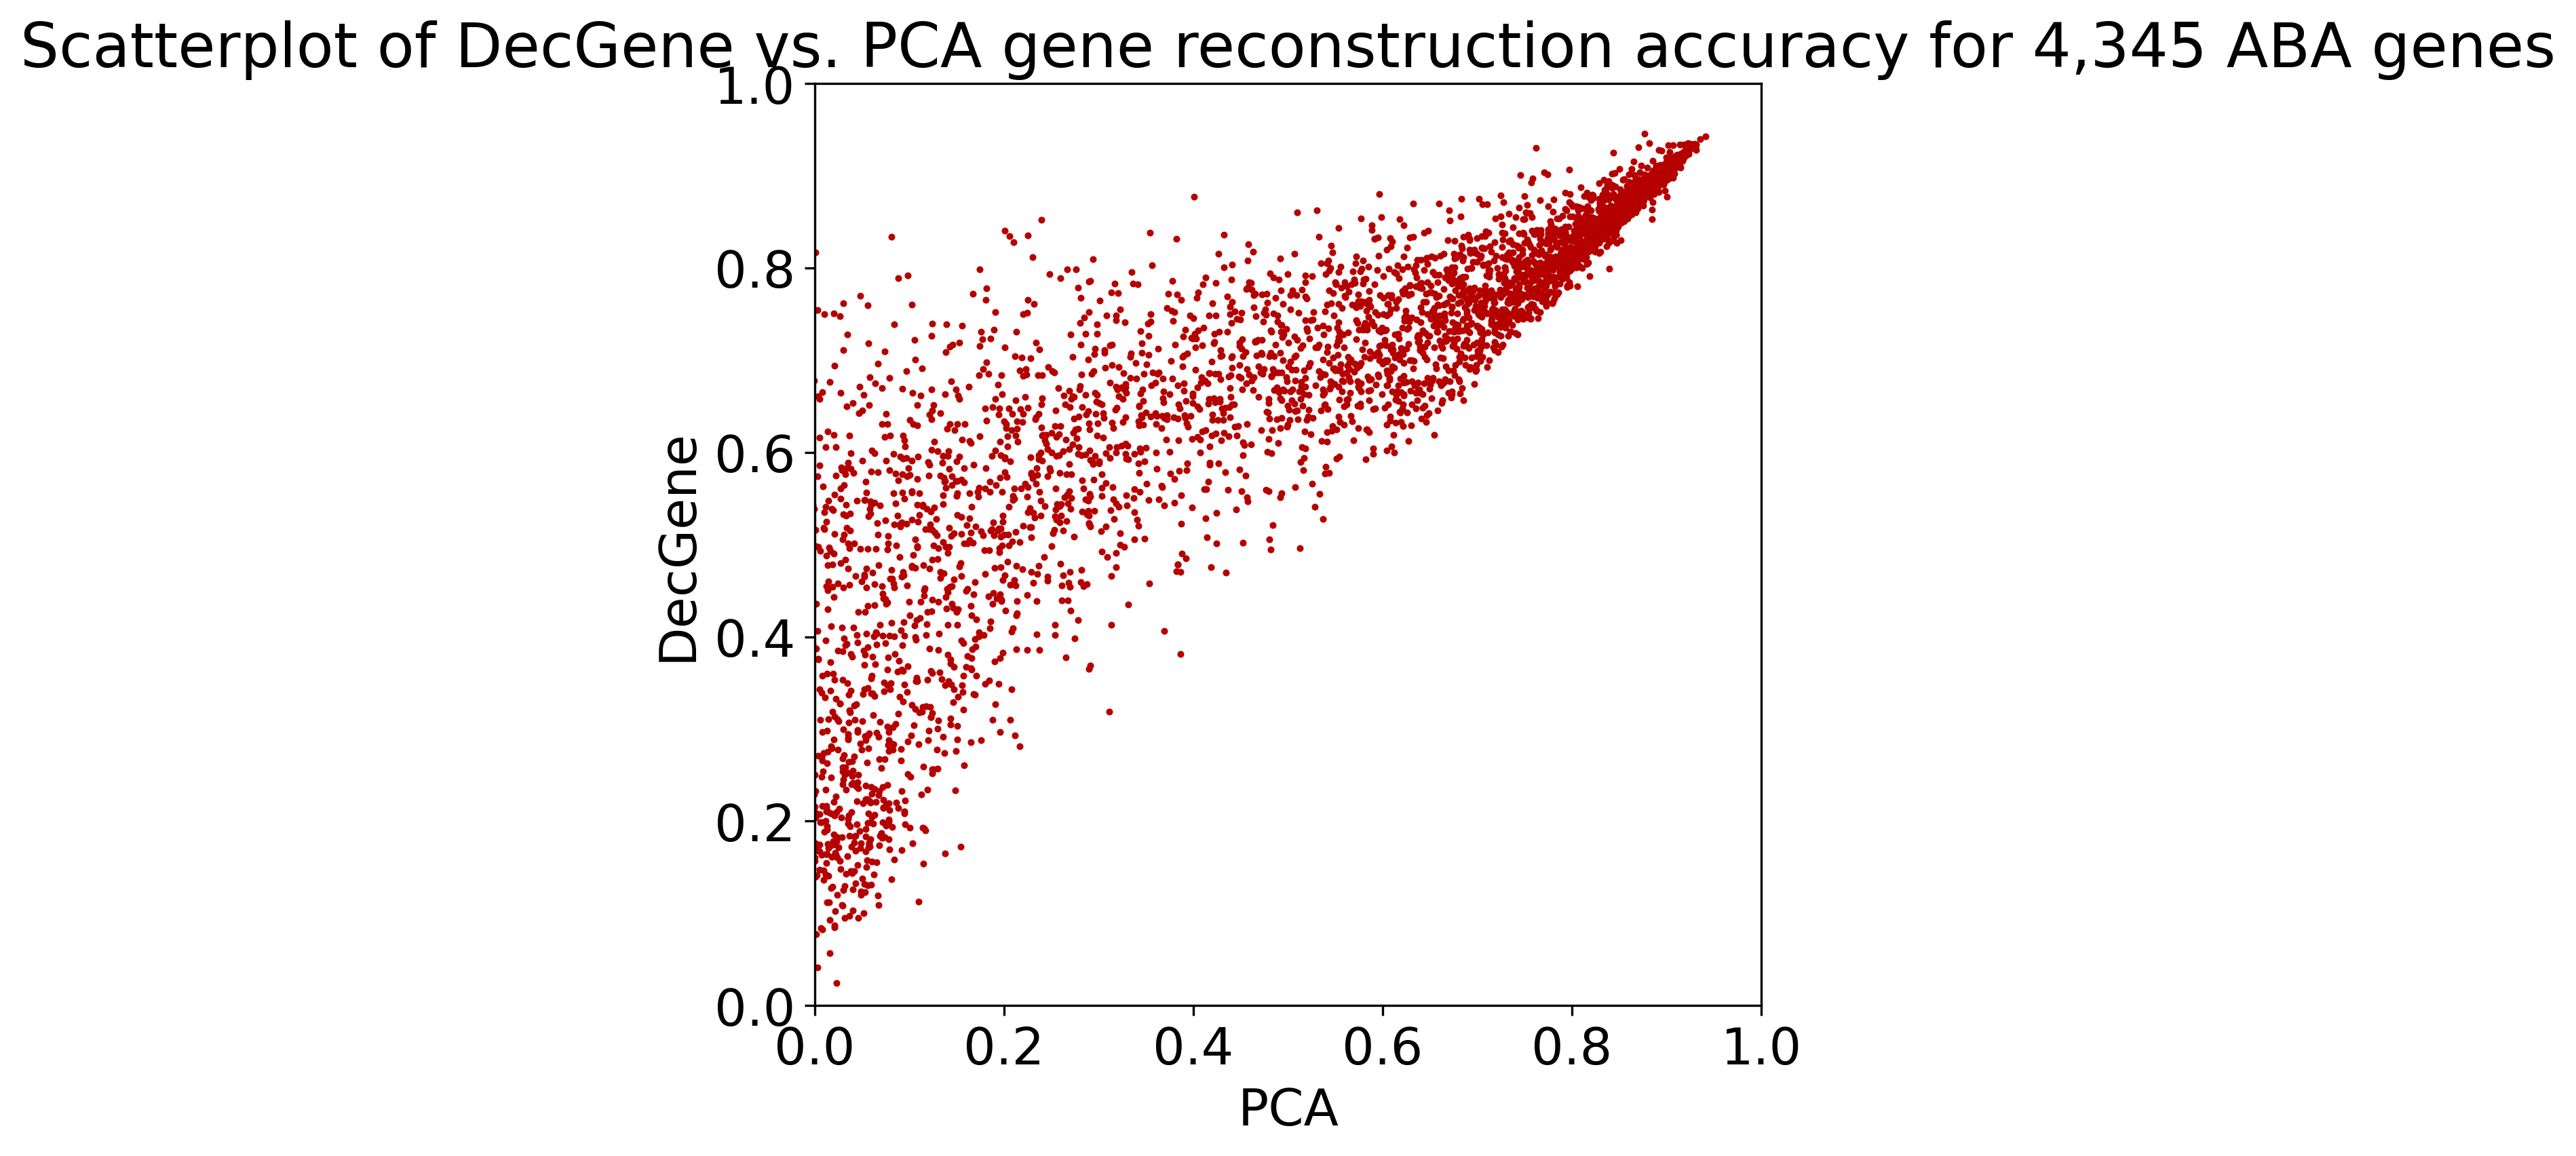

In [26]:
# Plot staNMF vs. PCA gene reconstruction correlations
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(gene_rec_accuracy_PCA, gene_rec_accuracy_staNMF, s=2,alpha=1, color='#B50000')
plt.title('Scatterplot of DecGene vs. PCA gene reconstruction accuracy for 4,345 ABA genes')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('PCA')
plt.ylabel('DecGene')
plt.savefig("../figures/gene_reconstruction.png", dpi=300, transparent=True)
plt.show()

## stability analysis of DecGene vs. PCA
Source: staNMF paper and code

**Fig. 1B** in manuscript

In [27]:
# # RUN SIMULATIONS OF EACH K VALUE
# # Note: this takes roughly an hour for every 100 replicates on a 2021 MacBook Pro M1.
# # For K=5 to K=50, this will take roughly ~45 hours. Our runs are saved.

# # Set key variables
# K1=5        # sets lower bound (including itself) of PPs
# K2=50       # sets upper bound (including itself) of PPs 
# B=100        # sets number of replicates
# start=0        # start number for naming replicates
# folder_path = '../output/instability_runs'

# # Set intermediate variables
# numPatterns = np.arange(K1, K2+1)

# # Run DG and PCA _num_set times to generate _num_set PPs
# for k in range(len(numPatterns)):
#     K = numPatterns[k]

#     # set new directory for K
#     path = folder_path + '/K=' + str(K)
#     try:
#         os.makedirs(path)
#     except OSError:
#         if not (os.path.isdir(path)):
#             raise

#     # prep for runs
#     print("Working on K = {}...".format(K))
    
#     for b in range(B):

#         # Bootstrap data and use same bootstrap input for DecGene & PCA
#         np.random.seed(b) # set seed based on s
#         X = np.maximum(filtered_data,0)
#         n_samples = X.shape[0]
#         bootstrap_X = X[np.random.choice(
#             n_samples,
#             n_samples,
#             replace=True)]

#         # run and save DecGene/staNMF
#         from sklearn_nmf import sklearn_nmf
#         nmf = sklearn_nmf(n_components=K, l1_ratio=1, alpha = 0, random_state=1)
#         nmf.fit(bootstrap_X) # fit model with bootstrapped data
#         PPs_tmp = nmf.components_
#         np.savez(path + '/DG_PP_' + str(b+start),PPs_tmp=PPs_tmp)
        
#         # run and save PCA
#         from pca_with_missing_values import pca_with_missing_values
#         pca = pca_with_missing_values(n_components=K)
#         pca.fit(bootstrap_X) # fit model
#         PPs_tmp = pca.components_
#         np.savez(path + '/PCA_PP_' + str(b+start),PPs_tmp=PPs_tmp)

In [28]:
# define find correlation function
def findcorrelation(_A, _B):
    '''
    Construct k by k matrix of Pearson product-moment correlation
    coefficients for every combination of two columns in A and B
    Parameters
    ----------
    A : array, shape (n_features, n_components)
        first NMF solution matrix
    B : array, shape (n_features, n_components)
        second NMF solution matrix, of same dimensions as A
    Returns
    -------
    X : array shape (n_components, n_components)
        array[a][b] is the correlation between column 'a' of X
        and column 'b'
    '''
    A_std = sklearn.preprocessing.normalize(_A, axis=0)
    B_std = sklearn.preprocessing.normalize(_B, axis=0)
    return A_std.T @ B_std

In [29]:
def HungarianError(_correlation):
    '''
    Compute error via Hungarian error
    based on average distance between factorization solutions
    Parameters
    ----------
    correlation: array, shape (n_components, n_components)
        cross correlation matrix
    Returns
    -------
    distM : double/float
        Hungarian distance
    '''

    n, m = _correlation.shape
    correlation = np.absolute(_correlation)  # ignore the sign of corr
    x, y = linear_sum_assignment(-_correlation)
    distM = np.mean([1 - _correlation[xx, yy] for xx, yy in zip(x, y)])
    return distM

In [30]:
def amariMaxError(_correlation):
    '''
    Compute what Wu et al. (2016) described as a 'amari-type error'
    based on average distance between factorization solutions
    Parameters
    ----------
    correlation: array, shape (n_components, n_components)
        cross correlation matrix
    Returns
    -------
    distM : double/float
        Amari distance
    '''

    n, m = _correlation.shape
    maxCol = np.absolute(_correlation).max(0)
    colTemp = np.mean((1-maxCol))
    maxRow = np.absolute(_correlation).max(1)
    rowTemp = np.mean((1-maxRow))
    distM = (rowTemp + colTemp)/(2)

    return distM

In [31]:
## BUILD FUNCTION FOR INSTABILITY

def instability(_folder_path, _k1, _k2, _numReplicates, _n_features=55954, _name="TBD"):
    '''
    Performs instability calculation for each K
    within the range entered
    Parameters
    ----------
    tag : str
        the name of the autoencoder model to compute the stability
    k1 : int, optional, default self.K1
        lower bound of K to compute stability
    k2 : int, optional, default self.K2
        upper bound of K to compute instability
    Returns
    -------
    None
    Side effects
    ------------
    "instability.csv" containing instability index
    for each K between and including k1 and k2; updates
    self.instabilitydict (required for makeplot())
    '''

    
    # create variables
    instabilitydict = {}
    instability_std = {}
    numPatterns = np.arange(_k1, _k2+1)
    
    # loop through each number of PPs
    for k in numPatterns:
        print("Calculating instability for " + str(k))
        # load the dictionaries
        path = _folder_path + '/K=' + str(k)
        Dhat = np.zeros((_numReplicates, _n_features, k))

        for replicate in range(_numReplicates):
            inputfilename = ('/' + _name + '_' + str(replicate) + '.npz')
            tmp = np.load(path + inputfilename, allow_pickle=True)
            PPs = tmp['PPs_tmp']
            Dhat[replicate] = PPs.T

        # compute the distance matrix between each pair of dicts
        distMat = np.zeros(shape=(_numReplicates, _numReplicates))

        for i in range(_numReplicates):
            for j in range(i, _numReplicates):
                x = Dhat[i]
                y = Dhat[j]

                CORR = findcorrelation(x, y)
                distMat[i][j] = HungarianError(CORR)
                distMat[j][i] = distMat[i][j]

        # compute the instability and the standard deviation
        instabilitydict[k] = (
                np.sum(distMat) / (_numReplicates * (_numReplicates-1))
        )
        # The standard deviation of the instability is tricky:
        # It is a U-statistic and in general hard to compute std.
        # Fortunately, there is a easy-to-understand upper bound.
        instability_std[k] = (np.sum(distMat ** 2)
                              / (_numReplicates * (_numReplicates - 1))
                              - instabilitydict[k] ** 2
                              ) ** .5 * (2 / distMat.shape[0]) ** .5
        # write the result into csv file
        outputfile = "../output/instability_runs/instability" + _name + ".csv"
        pd.DataFrame({
            'K': [k],
            'instability': [instabilitydict[k]],
            'instability_std': [instability_std[k]],
        }).to_csv(outputfile, mode='a', header=False, index=False)
    return instabilitydict, instability_std, distMat

In [ ]:
############################################
# Calculate Instability for DecGene and PCA
############################################

# Set key variables
K1=8       # sets lower bound (including itself) of PPs
K2=30       # sets upper bound (including itself) of PPs 
B=100       # sets number of replicates
folder_path = "../output/instability_runs"
name_DG="DG_PP"
name_PCA="PCA_PP"

from scipy.optimize import linear_sum_assignment
import sklearn.preprocessing


# Load data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz', allow_pickle=True)
data = tmp['imputed']
selected = tmp['selected']
del tmp

# Set intermediate variables
numPatterns = np.arange(K1, K2+1)
shape_flat = 55954

# Run instability
print("Run instability for DecGene:")
instability_DG, instability_std_DG, distMat_DG = instability(_folder_path=folder_path,
                                                             _k1=K1,
                                                             _k2=K2,
                                                             _numReplicates=B,
                                                             _n_features=shape_flat,
                                                             _name=name_DG)

# Run instability
print("\nRun instability for PCA:")
instability_PCA, instability_std_PCA, distMat_PCA = instability(_folder_path=folder_path,
                                                             _k1=K1,
                                                             _k2=K2,
                                                             _numReplicates=B,
                                                             _n_features=shape_flat,
                                                             _name=name_PCA)

Run instability for DecGene:
Calculating instability for 8
Calculating instability for 9
Calculating instability for 10
Calculating instability for 11
Calculating instability for 12
Calculating instability for 13
Calculating instability for 14
Calculating instability for 15
Calculating instability for 16
Calculating instability for 17
Calculating instability for 18
Calculating instability for 19
Calculating instability for 20


In [ ]:
np.savez("../output/instability_calcs.npz",
         instability_DG=instability_DG,
         instability_std_DG=instability_std_DG,
         instability_PCA=instability_PCA,
         instability_std_PCA=instability_std_PCA)

In [ ]:
# Plot instability curves for DG and PCA

# generate data
names = list(instability_DG.keys())
values1 = list(instability_DG.values())
values1_std = list(instability_std_DG.values())
values1_std = [item * 2 for item in values1_std] # multiply StdDev by 2
values2 = list(instability_PCA.values())
values2_std = list(instability_std_PCA.values())
values2_std = [item * 2 for item in values2_std] # multiply StdDev by 2

# plot chart with error bars
plt.figure(figsize=(8, 8))
plt.errorbar(range(len(instability_DG)), values1, values1_std, ecolor='#ED1C24', color='#ED1C24',
             capsize=5, linewidth=4, elinewidth=2)
plt.errorbar(range(len(instability_PCA)), values2, values2_std, ecolor='grey', color='grey',
             capsize=5, linewidth=4, elinewidth=2)
plt.xlabel('K (# of PPs)')
plt.ylabel("Instability Index")
plt.title("Instability by stage by # of PPs\n" +str(B) + " simulations per K value")
plt.xticks(range(K2-K1),range(K1,K2))
plt.axis([-2, (K2-K1+1), 0, 0.45])
# plt.legend(['DecGene', 'PCA'])
plt.savefig('../figures/instability.jpg', transparent=False, dpi=100)
plt.show()

In [ ]:
# # Plot instability curves for DG and PCA
# # dark background

# # plot chart with error bars
# plt.figure(figsize=(8, 8))
# plt.errorbar(range(len(instability_DG)), values1, values1_std, ecolor='white',color='red',
#              capsize=5, linewidth=4, elinewidth=4)
# plt.errorbar(range(len(instability_PCA)), values2, values2_std, ecolor='white',color='#939598',
#              capsize=5, linewidth=4, elinewidth=4)
# plt.xlabel('K (# of PPs)')
# plt.ylabel("Instability Index")
# plt.title("Instability by stage by # of PPs\n" +str(B) + " simulations per K value")
# plt.xticks(range(K2-K1),range(K1,K2))
# plt.axis([-1, (K2-K1+1), 0, 0.55])
# plt.legend(['DecGene', 'PCA'])
# plt.savefig('figures/instability.png', transparent=True, dpi=300)
# plt.show()

In [ ]:
# print("DecGene instability:", instability_DG[11])
# print("DecGene standard dev:", instability_std_DG[11])
# print("PCA instability:", instability_PCA[11])
# print("PCA standard dev:", instability_std_PCA[11])

# spatial coherence
Using Moran's I and Geary's C as measures. Uses morans_index.py for functions.

**Fig. 1D** in manuscript


In [ ]:
## Load existing data

# import data
MoranI = np.load('../output/manyruns_DG_PCA_2022_10_17.npz')
I_manyRuns_DG = MoranI["I_manyRuns_DG"]
I_manyRuns_PCA = MoranI["I_manyRuns_PCA"]

# # Load DecGene PPs
# tmp = np.load('staNMF_final_11_PPs.npz')
# PPs_DG = tmp['PPs_3d']

# # Load PCA PPs
# tmp = np.load('PCA_final_11_PPs.npz')
# PPs_PCA = tmp['PPs_3d']

### DecGene
# I_DG = MoranIforPPs(PPs_DG,_removeEmptyLayers=False)
print("---\nDecGene:", np.mean(I_manyRuns_DG), np.median(I_manyRuns_DG), np.std(I_manyRuns_DG))

### PCA
# I_PCA = MoranIforPPs(PPs_PCA,_removeEmptyLayers=False)
print("---\nPCA:", np.mean(I_manyRuns_PCA), np.median(I_manyRuns_PCA),np.std(I_manyRuns_PCA))

### Two-tailed test
#print(stats.ttest_ind(I_manyRuns_DG, I_manyRuns_PCA))


In [ ]:
# ## Calculate Moran's I across n runs per PP

# from morans_index import MoranIforPPs

# # set number of runs per PP
# n_runs = 20

# # set downsampling amount (delete every _n values across all axes)
# _downsample=2

# # Load DecGene PPs
# tmp = np.load('../output/DecGene_final_11_PPs.npz')
# PPs_DG = tmp['PPs_3d']

# # Load PCA PPs
# tmp = np.load('../output/PCA_final_11_PPs.npz')
# PPs_PCA = tmp['PPs_3d']

# # Load brain mask
# areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
# mask = np.max(areas_atlas, axis=0)

# PPs_3d_tmp=PPs_PCA
# _mask=mask

# ## DecGene
# I_manyRuns_DG = runManyMoranI(_n=n_runs,
#                               _DecGeneOrPCA="DecGene",
#                               _PPs=PPs_DG,
#                               _mask=mask,
#                               _downsample=_downsample)
# print("---\nDecGene:", np.mean(I_manyRuns_DG), np.median(I_manyRuns_DG), np.std(I_manyRuns_DG))

# ## PCA
# I_manyRuns_PCA = runManyMoranI(_n=n_runs,
#                               _DecGeneOrPCA="PCA",
#                               _PPs=PPs_PCA,
#                               _mask=mask,
#                               _downsample=_downsample)
# print("---\nPCA:", np.mean(I_manyRuns_PCA), np.median(I_manyRuns_PCA), np.std(I_manyRuns_PCA))

In [ ]:
# #save
# np.savez('../output/manyruns_DG_PCA_2022_10_17.npz',I_manyRuns_DG=I_manyRuns_DG,I_manyRuns_PCA=I_manyRuns_PCA)

In [ ]:
# # Create boxplots for DecGene vs. PCA

# # flatten data so all 20*11 samples are included
# I_DG = np.reshape(I_manyRuns_DG,(I_manyRuns_DG.shape[0]*I_manyRuns_DG.shape[1]))
# I_PCA = np.reshape(I_manyRuns_PCA,(I_manyRuns_PCA.shape[0]*I_manyRuns_PCA.shape[1]))

# ### Two-tailed test
# print(stats.ttest_ind(I_DG, I_PCA))

# #get data
# df1 = pd.DataFrame(data=I_DG,columns=["DecGene"])
# df2 = pd.DataFrame(data=I_PCA,columns=["PCA"])
# df1 = pd.concat([df1, df2],axis=1)
# my_pal = {"DecGene": '#ED1C24', "PCA": '#939598'}

# # figure
# sns.set(rc={'figure.figsize':(14,12)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})
# box1 = sns.boxplot(data=df1,width=0.5, palette=my_pal, linewidth=6,
#                    flierprops={"markerfacecolor":'white',
#                                "markersize":.1, 
#                                "markeredgecolor":'white'})
# # box1.set_ylim(0, 1)
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
#     line.set(linewidth=6)

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransIboxPlot.png",dpi=300)

In [ ]:
# # create jittered scatterplot to combine with boxplots for figure 1D

# #x-axis
# x_DG = np.random.randint(100, size=I_DG.shape[0]) # to jitter the data points
# x_PCA = np.random.randint(100, size=I_PCA.shape[0]) # to jitter the data points

# #plot DG
# plt.scatter(x_DG,I_DG, color='#ED1C24')
# plt.xlim(-700,800)
# plt.ylim(0,1)
# plt.savefig("../figures/Moran_scatter_DG.png",dpi=300)
# plt.clf()

# #plot PCA
# plt.scatter(x_PCA,I_PCA, color='grey')
# plt.xlim(-700,800)
# plt.ylim(0,1)
# plt.savefig("../figures/Moran_scatter_PCA.png",dpi=300)

In [ ]:
# # Create boxplots for DG and PCA, in order of DG PPs

# # # import data
# # MoranI_DG = np.load('MoranI_20_runs_DG.npz')
# # I_manyRuns_DG = MoranI_DG["I_manyRuns_DG"]
# # MoranI_PCA = np.load('MoranI_20_runs_PCA.npz')
# # I_manyRuns_PCA = MoranI_PCA["I_manyRuns_PCA"]

# # convert to dataframe for input
# df = pd.DataFrame(data=I_manyRuns_DG,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # figure
# sns.set(rc={'figure.figsize':(20,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})

# #DG
# box1 = sns.boxplot(data=df, color='#ED1C24', linewidth=4, width=0.3,
#                    flierprops={"markerfacecolor":'#ED1C24',
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
# #     line.set(linewidth=1)
# #     line.set_mfc("black")
#     line.set_mec("black")

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_DG_sims.png",transparent=True,dpi=300)

In [ ]:
# # Create boxplots for PCA by PPA

# # # import data
# # MoranI_PCA = np.load('../output/MoranI_20_runs_PCA.npz')
# # I_manyRuns_PCA = MoranI_PCA["I_manyRuns_PCA"]

# # convert to dataframe for input
# df = pd.DataFrame(data=I_manyRuns_PCA,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # figure
# sns.set(rc={'figure.figsize':(14,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})

# #DG
# box1 = sns.boxplot(data=df, color='grey', linewidth=4, width=0.3,
#                    flierprops={"markerfacecolor":'grey',
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
# #     line.set(linewidth=1)
# #     line.set_mfc("black")
#     line.set_mec("black")

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_PCA_sims.png",transparent=True,dpi=300)

In [ ]:
# # Means & std
# print("DG mean for Moran's I:", np.mean(I_manyRuns_DG))
# print("DG std for Moran's I:", np.std(I_manyRuns_DG))
# print("PCA mean for Moran's I:", np.mean(I_manyRuns_PCA))
# print("PCA std for Moran's I:", np.std(I_manyRuns_PCA))

In [ ]:
# # create joint boxplot

# # create blank dataframe
# df_output = pd.DataFrame(columns=("moranI", "PP", "DGorPCA"))

# # add DG runs to a dataframe
# df_DG = pd.DataFrame(data=I_manyRuns_DG,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # add PCA runs to a dataframe, re-ordered for maximum similarity to DG
# df_PCA = pd.DataFrame(data=I_manyRuns_PCA,columns=[2,7,3,4,6,8,1,5,9,10,11])

# # add rows to output dataframe
# for pp in range(df_DG.shape[1]):
#     for run in range(df_DG.shape[0]):
        
#         # for DG
#         dict = {'moranI': [df_DG[pp+1][run]], 'PP': str([pp+1]), 'DGorPCA': ["DecGene"]}
#         add_tmp = pd.DataFrame(dict)
#         df_output = pd.concat([df_output,add_tmp], axis=0)
        
#         # for PCA
#         dict = {'moranI': [df_PCA[pp+1][run]], 'PP': str([pp+1]), 'DGorPCA': ["PCA"]}
#         add_tmp = pd.DataFrame(dict)
#         df_output = pd.concat([df_output,add_tmp], axis=0)

# # show plot
# sns.set(rc={'figure.figsize':(14,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# box1 = sns.boxplot(data=df_output, x="PP", y="moranI",hue="DGorPCA", width=0.5, linewidth=2,
#                    palette=['#ED1C24', "grey"],
#                    flierprops={"markerfacecolor":"black",
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylim=(0, 1))
# box1.legend_.remove()
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_DG_PCA_PPs.png",transparent=True,dpi=300)

# pixel analysis

In [ ]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz', allow_pickle=True)
data_original = tmp['data']
sections = tmp['sections'].item()
gene_ids = list(sections.keys())
original_shape = data_original.shape
# d = data.shape[1] * data.shape[2] * data.shape[3]
# data = np.reshape(data, (data.shape[0], d))

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.argmax(nmf.components_,axis=0),bins=np.arange(-.5,11.5,1),facecolor='orange',edgecolor='r',orientation='horizontal')
plt.yticks(np.arange(0,11))
plt.axis='off'
plt.gca().invert_yaxis()
plt.xlabel('PP category size')
plt.savefig("../figures/pixel_analysis1", dpi=300)
plt.show()

In [ ]:
gene_inds = []
for pp_ind in range(nmf.components_.shape[0]):
    gene_per_pp = np.where(np.argmax(nmf.components_,axis=0)==pp_ind)[0]
    gene_inds = np.concatenate((gene_inds, gene_per_pp))
gene_inds = gene_inds.astype(int)
D_sorted = nmf.components_[:,gene_inds]

In [ ]:
plt.figure(figsize=(20,4))
plt.imshow(D_sorted,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(np.arange(0,11))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.savefig("../figures/pixel_analysis2", dpi=300)
plt.colorbar()

# marker genes

**Fig. 5A-C** in manuscript

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.argmax(coeffs,axis=1),bins=np.arange(-.5,11.5,1),facecolor='grey',edgecolor='black',orientation='horizontal')
plt.yticks(np.arange(0,11))
plt.axis='off'
plt.gca().invert_yaxis()
plt.xlabel('PP category size')
plt.savefig("../figures/markergenes1", dpi=300)
plt.show()

In [ ]:
# sort based on loading
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind])[::-1]
    gene_per_pp_arg_sort = np.argsort(coeffs[gene_per_pp,pp_ind])[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# sort based on amplitude score
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)#+np.sum(coeffs[gene_per_pp,pp_ind+1:],axis=1))

#     gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind]/(np.sum(coeffs[gene_per_pp,:pp_ind])+np.sum(coeffs[gene_per_pp,pp_ind+1:])))[::-1]
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# sort PP max correlation to CCF, in descending order
PP_order_lst = [3,2,8,1,6,0,9,5,7,4,10]
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in PP_order_lst:
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)#+np.sum(coeffs[gene_per_pp,pp_ind+1:],axis=1))

#     gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind]/(np.sum(coeffs[gene_per_pp,:pp_ind])+np.sum(coeffs[gene_per_pp,pp_ind+1:])))[::-1]
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# create figure "Coefficient amplitudes of DecGene transformation"

coeffs_ordered = coeffs_sorted.T[PP_order_lst]
plt.figure(figsize=(20,4))
plt.imshow(coeffs_ordered,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(np.arange(0,11))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.savefig("../figures/markergene_index", dpi=300)
plt.colorbar()
plt.savefig("../figures/colorbar", dpi=300)

In [ ]:
#visualize genes

for pp_ind in range(11):
    print(pp_ind)
    for gene_rank in range(3):
#         _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
#         gene_ind = top_10_genes[pp_ind, gene_rank].astype(int)
#         print(gene_ind)
#         a.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 2).T)
#         b.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1))
#         c.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 0))
#         a.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         b.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         c.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
#         b.axes.get_xaxis().set_visible(False)
#         b.axes.get_yaxis().set_visible(False)
#         c.axes.get_xaxis().set_visible(False)
#         c.axes.get_yaxis().set_visible(False)
        _, (b) = plt.subplots(1, 1, figsize=(5, 5))
        gene_ind = top_10_genes[pp_ind, gene_rank].astype(int)
        print(gene_ind)
        b.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1), cmap="copper")
        b.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
        b.axes.get_xaxis().set_visible(False)
        b.axes.get_yaxis().set_visible(False)
       #uncomment to save figures to local machine
        plt.savefig("../figures/marker_genes_PP" + str(pp_ind) + "_" + str(gene_rank) + ".png", dpi=300)
        plt.show()


# compute networks

In [ ]:
def filter_genes(coefs, pps, threshold = .99):
    large_coefs = np.max(coefs[:, pps], 1) / np.sum(coefs, 1)
    return large_coefs > np.quantile(large_coefs, threshold)

In [ ]:
def weighted_correlation(A, weights, demean=True):
    '''
    Compute the weighted correlation between columns of A using the weights.
    '''
    if demean:
        A = A - np.mean(A, 0, keepdims=True)
    mean_A = 0#np.sum(A * weights, 1, keepdims=True) / np.sum(weights)
    cov = (A - mean_A) @ (A - mean_A).T
    corr = np.diag(np.diag(cov) ** -.5) @ cov @ np.diag(np.diag(cov)**-.5)
    return corr

In [ ]:
unique_gene_names = np.unique(list(sections.values()))

unique_X = np.zeros((len(unique_gene_names), filtered_data.shape[1]))

for ind, name in enumerate(unique_gene_names):
    gene_ids = np.where([x == name for x in sections.values()])[0]
    #print(gene_ids)
    unique_X[ind,:] = np.mean(filtered_data[gene_ids,:], 0)

In [ ]:
# solve the coefs
unique_X = unique_X.astype('float32')
unique_coefs = nmf.transform(np.maximum(unique_X, 0))

# correlation network
**Fig. 6** in the manuscript

In [ ]:
def show_graph_with_labels(adjacency_matrix, mylabels, colors, title=""):
    #plt.figure(figsize=(30,30))
    fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True,figsize=(25,14))
    rows, cols = np.where(adjacency_matrix > 0)
    edges = [(x, y) for x, y in zip(rows.tolist(), cols.tolist()) if x > y]
    edge_colors = np.array([adjacency_matrix[edge[0], edge[1]] for edge in edges])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    remove = [node for node,degree in gr.degree() if degree <= 0.5]
    colors = [x for x, y in zip(colors, gr.degree()) if y[1] > 0.5]
    edge_colors = [y for x, y in zip(edges, edge_colors) if gr.degree()[x[0]] > 0.5 and gr.degree()[x[1]] > 0.5]
    
    gr.remove_nodes_from(remove)
    nodes = set(ind for ind, name in gr.degree())
    pos = nx.circular_layout(gr)
    f1_axes[1,1].set_xlim([-2, 2])
    plt.ylim([-2, 2])
    nx.draw(
        gr,
        pos,
        node_size=300,
        labels={k:v for k, v in mylabels.items() if k in gr},
        node_color=colors,
        with_labels=False,
        cmap=plt.cm.copper_r,
    )
    nx.draw_networkx_edges(
        gr,
        pos,
        gr.edges(),
        edge_color=edge_colors,
        edge_cmap=plt.cm.Greys,
    )
    description = nx.draw_networkx_labels(gr,{k:(v[0] * 1.25, v[1] * 1.25) for k, v in pos.items()},labels={k:v for k, v in mylabels.items() if k in gr})
    sm = plt.cm.ScalarMappable(cmap=plt.cm.copper_r, norm=plt.Normalize(vmin = np.min(colors), vmax=np.max(colors)))
    sm._A = []
    plt.colorbar(sm)
    plt.title(title)
    plt.savefig("../figures/network_names{}.png".format(title), dpi=300)
    plt.show()

In [ ]:
## pps = [16, 14, 6]
#pps = [5, 13, 12]
#pps = [4,8,9]
#pps = [0, 6, 8, 9, 12, 14, 15]
for i in range(11):
    pps = [i]
    weights = np.mean(nmf.components_[pps], 0)
    selected_gene_ids = filter_genes(unique_coefs, pps, threshold=0.9975)
    correlations = weighted_correlation(unique_X[selected_gene_ids,:], weights, demean=True)
    #correlations = np.corrcoef(X_guess[selected_gene_ids,:] * weights ** .5) 
    selected_gene_names = unique_gene_names[selected_gene_ids]
    colors = (
        unique_coefs[selected_gene_ids, pps[0]]/
        np.sum(unique_coefs[selected_gene_ids], axis=1)
    )
    upper_bound = 0 #np.percentile(correlations.flatten(), 0)
    adj_matrix = correlations #> upper_bound
    adj_matrix[correlations <= upper_bound] = 0
    show_graph_with_labels(adj_matrix, {ind: name for ind, name in enumerate(selected_gene_names)}, 
                       colors=colors,title="PP{}".format(i))